In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

In [18]:
sns.set(style="whitegrid", palette="muted", font_scale=1.1)
palette_20 = [
    '#AF3029', '#D1473F', '#F25C55', '#BC5215', '#D97A3D', 
    '#F2A66B', '#AD8301', '#C7A21C', '#E1C138', '#66800B',
    '#80982D', '#99B54E', '#24837B', '#3E9A8C', '#58B1A0', 
    '#205EA6', '#4176C1', '#5E409D', '#7B63B0', '#9986C3',
]

mirna_sequence_records_path = "/home/l/leitzb/miRNA/Harmonization-of-miRNA-databases/output/mirna_sequence_records.csv"
species_map_path = "/home/l/leitzb/miRNA/Harmonization-of-miRNA-databases/output/taxon_id_species_name_and_abbr.csv"

data_df = pd.read_csv(mirna_sequence_records_path, dtype={"source_db_version": str, "taxon_id": str})
species_map = pd.read_csv(species_map_path, dtype={"taxon_id": str})

In [19]:
taxon_to_species = (
    species_map.groupby("taxon_id")["species_name"]
    .first()  # oder .min(), .max(), ...
    .to_dict()
)

In [3]:
def set_plot_styles():

    styles = {
        # remove the top and right spines from the plots
        'axes.spines.right': False,
        'axes.spines.top': False,
        
        # color palette configuration
        'image.lut': 256,
        'axes.prop_cycle': mpl.cycler('color', ['#AF3029','#5E409D', '#BC5215', '#AD8301', '#66800B', '#24837B', '#205EA6' , '#A02F6F']),
        
        # retina figures configuration
        'figure.dpi': 300,
        'savefig.dpi': 300,
    }
    
    mpl.rcParams.update(styles)

In [13]:
# Count top 20 organisms per database and overall
counts_per_organism_all = data_df.groupby(["taxon_id"])["miRNA_id"].nunique().reset_index()
counts_per_organism_all.columns = ["taxon_id", "miRNA_count"]
counts_per_organism_all["source_db"] = "All Databases"
top20_overall = counts_per_organism_all.nlargest(20, "miRNA_count")

counts_per_organism = data_df.groupby(["source_db", "taxon_id"]).size().reset_index(name="miRNA_count")
top20_per_db = counts_per_organism.groupby("source_db")[["taxon_id", "miRNA_count"]].apply(
    lambda x: x.nlargest(20, "miRNA_count")
    ).reset_index()

In [17]:
# Combine both top 20s, get max and sort databases by max
top20_combined = pd.concat([top20_per_db, top20_overall], ignore_index=True) # Now also all database top 20 is included

max_per_db = top20_combined.groupby("source_db")["miRNA_count"].max().reset_index()
sorted_dbs = max_per_db.sort_values("miRNA_count", ascending=False)["source_db"].tolist()

In [20]:
# Map taxon_id back to species_name for better readability in plots
top20_combined["species_name"] = top20_combined["taxon_id"].map(taxon_to_species)
top20_combined.drop(columns=["taxon_id"], inplace=True)

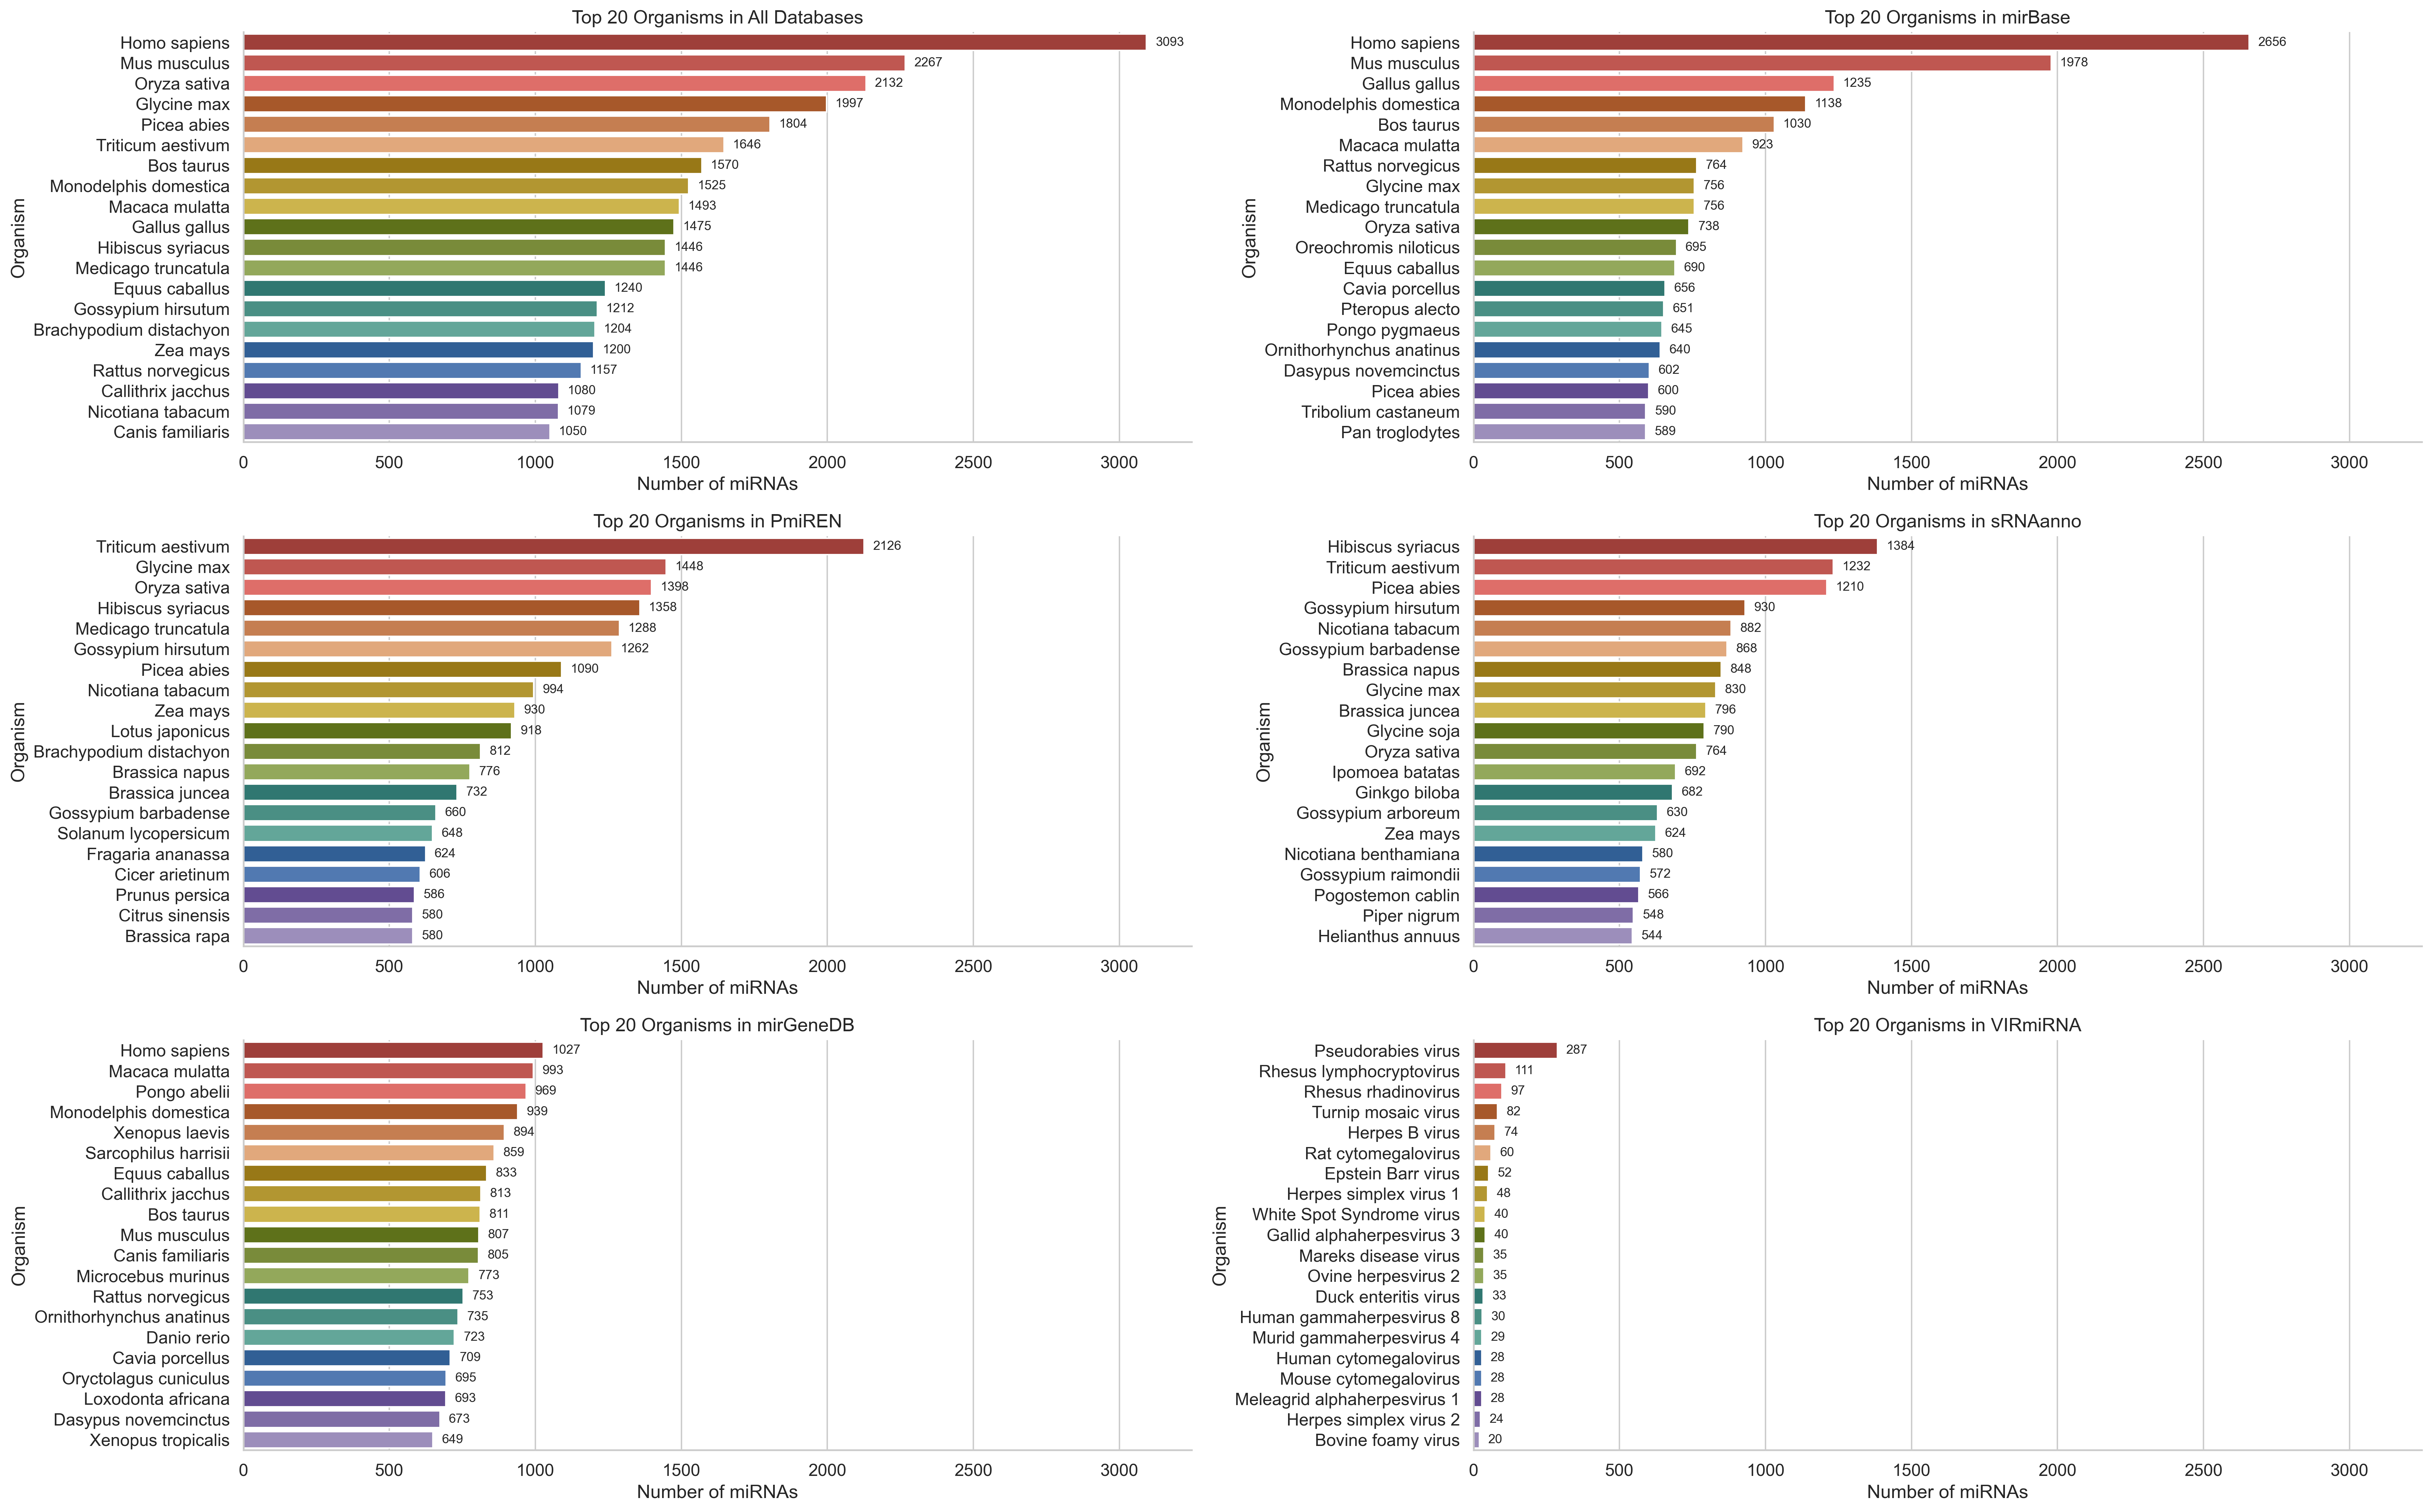

In [23]:
# Plotting
n_dbs = len(sorted_dbs)
nrows = (n_dbs + 1) // 2  # Two plots per row
ncols = 2
set_plot_styles()
fig, axes = plt.subplots(nrows, ncols, figsize=(12 * ncols, 5 * nrows))
axes = axes.flatten()
max_count = top20_combined["miRNA_count"].max()
for ax, db in zip(axes, sorted_dbs):
    db_data = top20_combined[top20_combined["source_db"] == db]
    sns.barplot(
        data=db_data,
        x="miRNA_count",
        y="species_name",
        hue="species_name",
        ax=ax,
        palette=palette_20,
        legend=False
    )
    ax.set_title(f"Top 20 Organisms in {db}")
    ax.set_xlabel("Number of miRNAs")
    ax.set_ylabel("Organism")
    ax.set_xlim(0, max_count * 1.05)
    # Set counts on bars
    for bar, count in zip(ax.patches, db_data["miRNA_count"]):
        width = bar.get_width()
        y = bar.get_y() + bar.get_height() / 2
        ax.text(
            width + max_count*0.01, 
            y,
            f'{count}',
            va='center',
            fontsize=9
        )

for ax in axes[len(sorted_dbs):]:
    ax.set_visible(False)


plt.tight_layout()
plt.savefig("/home/l/leitzb/miRNA/Harmonization-of-miRNA-databases/output/plots/top20_organisms_per_db_subplots.png")
plt.show()
plt.close()